### SNA & MDS

In [1]:
import operator
import numpy as np
import seaborn as sns
import pandas as pd
import scipy

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Tahoma']

In [3]:
import matplotlib.pyplot as plt
import networkx as nx

from sklearn.manifold import MDS
from pygsp import graphs

In [4]:
import nltk
from nltk import bigrams
import collections

In [5]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

In [6]:
# Files definition
comment_bow = 'output\cooc_bow_all.csv'
comment_jacc = 'output\comment_cooc_jacc.xlsx' # Similarity measure

In [7]:
brands = ['ซีพีเมจิ','ดัชมิลล์','โฟร์โมสต์','แดรี่โฮม','โชคชัย','เอ็มมิลค์','ไทยเดนมาร์ค']

เปิดไฟล์ที่ได้จากขั้นตอน Data Prep

In [8]:
cooc_matrix_bow = pd.read_csv(comment_bow,index_col=0)
cooc_matrix_jacc= pd.read_excel(comment_jacc,index_col=0)

In [9]:
cooc_matrix_bow.shape

(12546, 496)

In [10]:
matrix_freq_brand = cooc_matrix_bow[brands]
matrix_freq_unbrand = cooc_matrix_bow.drop(labels=brands,axis=1,inplace=False)

### MDS Visualization

In [11]:
# https://scikit-learn.org/stable/auto_examples/manifold/plot_mds.html
# https://scikit-learn.org/stable/modules/generated/sklearn.manifold.MDS.html

In [12]:
def jaccard_precompute(df_b, df_attr , i, j, k):
    brand1 = pd.DataFrame(df_b.iloc[:,i])
    brand2 = pd.DataFrame(df_b.iloc[:,j])
    attr = pd.DataFrame(df_attr.iloc[:,k])
    slice_df = pd.concat([brand1, attr, brand2], axis=1, join="inner")
    a_in_b = slice_df[(slice_df.iloc[:,0]>0)&(slice_df.iloc[:,1]>0)&(slice_df.iloc[:,2]>0)]
    a_occur = slice_df[(slice_df.iloc[:,0]>0)&(slice_df.iloc[:,1]>0)]
    b_occur = slice_df[(slice_df.iloc[:,2]>0)&(slice_df.iloc[:,1]>0)]
    jacc_index = a_in_b.shape[0]/(a_occur.shape[0]+b_occur.shape[0]-a_in_b.shape[0])
    return jacc_index

In [13]:
# Co-occurrence dissimilarity (distance = 1-index) ใช้กับ MDS (อย่าใช้ similarity)
def gen_precomputed_matrix(df_b, df_attr):
    precomputed_matrix = pd.DataFrame(index=df_b.columns,columns=df_b.columns).fillna(0)
    
    jacc = pd.DataFrame(columns=df_attr.columns)
    jacc = jacc.append(pd.Series([],dtype='float64'), ignore_index=True).fillna(0.0)
    
    for i in range(0,len(precomputed_matrix.columns)):
        for j in range(0,len(precomputed_matrix.columns)):
            for k in range(0,len(df_attr.columns)): # 0 to 329
                try:
                    jacc.iloc[0,k] = 1-jaccard_precompute(df_b, df_attr,i, j, k)
                except Exception:
                    jacc.iloc[0,k] = None
                    continue
            precomputed_matrix.iloc[i,j] = jacc.mean(axis=1)[0]
            jacc = jacc.iloc[0:0].append(pd.Series([],dtype='float64'), ignore_index=True).fillna(0.0)
    return precomputed_matrix

In [14]:
def create_MDS_perceptual_map(df, attrName, dissim):
    embedding = MDS(n_components=2, dissimilarity=dissim)
    mds_coord = embedding.fit_transform(df)
    fig, ax=plt.subplots(figsize=(10,5))
    ax.set_title(f'MDS Perceptual map: {attrName}', fontsize=20)
    plt.scatter(mds_coord[:,0],mds_coord[:,1])
    labels=df.index
    for label,x,y in zip(labels, mds_coord[:,0], mds_coord[:,1]):
        plt.annotate(label,(x,y), fontsize=13)
    plt.axhline(y=0, color='k', linestyle='-', linewidth=1)
    plt.axvline(x=0, color='k', linestyle='-', linewidth=1)
    plt.xlabel('PC1', fontsize=16)
    plt.ylabel('PC2', fontsize=16)
    plt.grid(True)
    plt.show()
    return mds_coord.shape, embedding

In [15]:
# Transpose frequency into Attribute Rating Format for Euclidean distance MDS
#cooc_matrix_freq = cooc_matrix_freq[brands].T
#cooc_matrix_freq.drop(axis=1, columns=brands, inplace=True)

# Transpose frequency into Attribute Rating Format for precompute MDS
#cooc_matrix_freq = cooc_matrix_freq[brands]
#cooc_matrix_freq.drop(brands, axis=0, inplace=True)
#cooc_matrix_freq = cooc_matrix_freq.T

In [16]:
dissim = ['euclidean', 'precomputed']
promotions = ['แถม','แพคคู่','โปรโมชั่น','โปรโมต','การลดราคา','ของแถม','ชิม','ลดราคา']
mixtures = ['dha','เวย์โปรตีน','แคลเซียม','แป้ง','แมกนีเซียม','แลคโตส','แลคติก','แอนตี้ไบโอติก','แอลคานีทีน','โซเดียม','โปรตีน','โพแทสเซียม'
            ,'โฟเลต','โอเมก้า','ไขมัน','ไมอิลีน','ไอโอดีน','กรดอะมิโน','กลูโคส','กาเฟอีน','คาเฟอีน','คาร์โบไฮเดรต','ซูโครส','ธาตุเหล็ก'
            ,'ธาตุอาหาร','น้ำ','น้ำตาล','น้ำตาลเทียม','น้ำตาลทราย','น้ำตาลทรายแดง','วิตามิน','สารอาหาร','หางนม','กรดไขมัน']
heathcare = ['whey formula','เครียด','เตี้ย','เบาหวาน','เพาะกาย','เพิ่มน้ำหนัก','เล่นเวท','เล่นกล้าม','เวย์โปรตีน','เสริมสร้างกระดูก','เสริมสร้างร่างกาย','เอนไซม์','แข็งแรง','แคลอรี่','แพ้','แพ้นม','โด๊ป','โภชนาการ','โรคเบาหวาน','โรคโลหิตจาง','โรคประจำตัว','โรคมะเร็ง','โลหิตจาง','ไขมัน 0%','ไขมันต่ำ','ไขมันทรานส์','ไฮแคลเซียม','ไฮโปรตีน','กระเพาะ','กระเพาะอาหาร','กระดูก','กระดูกแข็งแรง','กระดูกพรุน','กระดูกสันหลัง','กระดูกอ่อน','กล้าม','กล้ามเนื้อ','การเจริญเติบโต','การเล่นกีฬา','การฉายแสง','การย่อยอาหาร','การลดน้ำหนัก','การออกกำลังกาย','ขับถ่าย','ขาดสารอาหาร','คลื่นไส้','ความดัน','ความสูง','ความหวาน','ความอ้วน','คอเลสเตอรอล','คอลลาเจน','คุณประโยชน์','คุมอาหาร','ช่องท้อง','ชั่งน้ำหนัก','ซ่อมแซมส่วนที่สึกหรอ','ดูแลสุขภาพ','ตัวเตี้ย','ตัวเล็ก','ตัวสูง','ท้องเสีย','ท้องผูก','ท้องร่วง','ท้องว่าง','ท้องอืด','นอนหลับ','นักโภชนาการ','นักกีฬา','บำรุง','บำรุงกำลัง','ปวดท้อง','ผิดปกติ','พลังงาน','พิษสุนัขบ้า','ฟันผุ','ฟิต','ฟิตเนส','ฟื้นฟูสภาพ','ภูมิแพ้','มวลกระดูก','มะเร็ง','ระบบขับถ่าย','รักษาสุขภาพ','ลดความอ้วน','ลดน้ำหนัก','ส่วนสูง','สุขภาพ','สุขอนามัย','สูง','หลังอาหาร','หายป่วย','อดอาหาร','อยากสูง','ออกกำลัง','ออกกำลังกาย','อักเสบ','อัลบูมิน','อาเจียน']
momchild = ['เด็ก','เด็กเล็ก','เด็กแรกเกิด','เด็กโต','เด็กผู้ชาย','เด็กวัยเรียน','เด็กอ่อน','เลี้ยงลูก','แปรงฟัน','แพ้ท้อง','แม่','แม่ลูกอ่อน','ให้นม','คนท้อง','คลอด','คลอดลูก','คุณแม่','ชงนม','ตั้งครรภ์','ตั้งท้อง','ท้อง','นมแม่','ประถม','ฝากครรภ์','ฝากท้อง','มีครรภ์','มีครอบครัว','มีลูก','ลูก','ลูกชาย','ลูกสาว','หย่านม']
coffee = ['อาหาร','เอสเพรสโซ่','โอวัลติน','โฮลวีท','ไมโล','กาแฟ','กาแฟเย็น','กาแฟร้อน','กาแฟสด','ขนม','ขนมเค้ก','ขนมปัง','ขนมหวาน','คาปูชิโน','ชง','ชงกาแฟ','ทำฟอง','ทำอาหาร','มอคค่า','ลาเต้','อเมริกาโน']
standard = ['haccp','เหม็นเปรี้ยว','เหม็นบูด','แบคทีเรีย','กระบวนการผลิต','การบูด','ของเสีย','ความสะอาด','คุณภาพ','ตะกอน','บรรจุภัณฑ์','บุบ','บูด','ปนเปื้อน','ปริมาตร','วันหมดอายุ','สะอาด','สารเคมี','สารสังเคราะห์','สิ่งแปลกปลอม','สิ่งปลอมปน','หมดอายุ']
price = ['ความคุ้มค่า','คุ้มค่า','ราคาแพง','ราคาถูก']
finding = ['เป็นประจำ','ไม่คุ้มค่า','ขาย','ขายไม่ดี','ขายไม่ออก','ขายดี','ขายปลีก','ขายส่ง','ซื้อประจำ','หาซื้อ','หายาก','หาซื้อไม่ได้']

In [17]:
precomMat_overall = gen_precomputed_matrix(matrix_freq_brand,matrix_freq_unbrand)
precomMat_promotion = gen_precomputed_matrix(matrix_freq_brand,matrix_freq_unbrand[promotions])

In [18]:
precomMat_mixtures = gen_precomputed_matrix(matrix_freq_brand,matrix_freq_unbrand[mixtures])
precomMat_heathcare = gen_precomputed_matrix(matrix_freq_brand,matrix_freq_unbrand[heathcare])
precomMat_momchild = gen_precomputed_matrix(matrix_freq_brand,matrix_freq_unbrand[momchild])
precomMat_coffee = gen_precomputed_matrix(matrix_freq_brand,matrix_freq_unbrand[coffee])
precomMat_standard = gen_precomputed_matrix(matrix_freq_brand,matrix_freq_unbrand[standard])
precomMat_price = gen_precomputed_matrix(matrix_freq_brand,matrix_freq_unbrand[price])
precomMat_finding = gen_precomputed_matrix(matrix_freq_brand,matrix_freq_unbrand[finding])

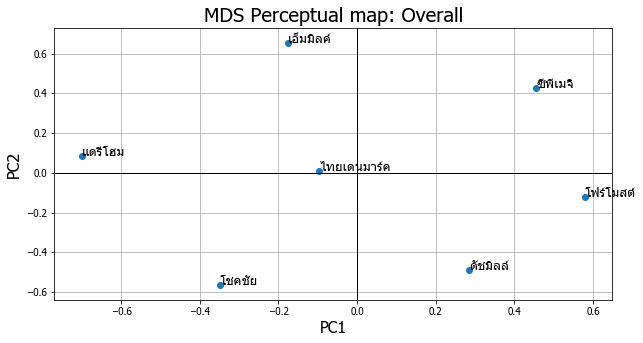

((7, 2), MDS(dissimilarity='precomputed'))

In [19]:
create_MDS_perceptual_map(precomMat_overall,'Overall', dissim[1])

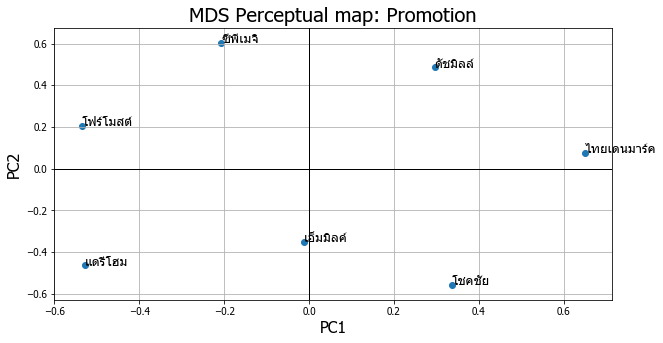

((7, 2), MDS(dissimilarity='precomputed'))

In [20]:
create_MDS_perceptual_map(precomMat_promotion,'Promotion', dissim[1])

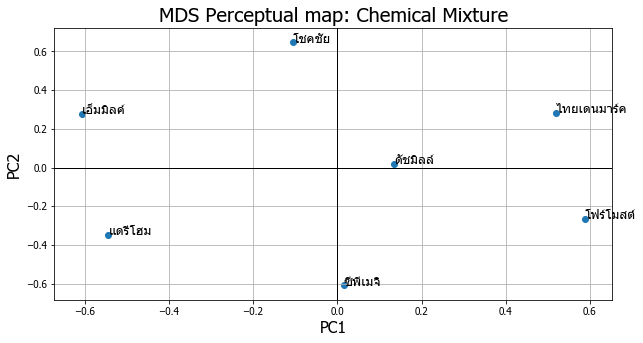

((7, 2), MDS(dissimilarity='precomputed'))

In [21]:
create_MDS_perceptual_map(precomMat_mixtures,'Chemical Mixture', dissim[1])

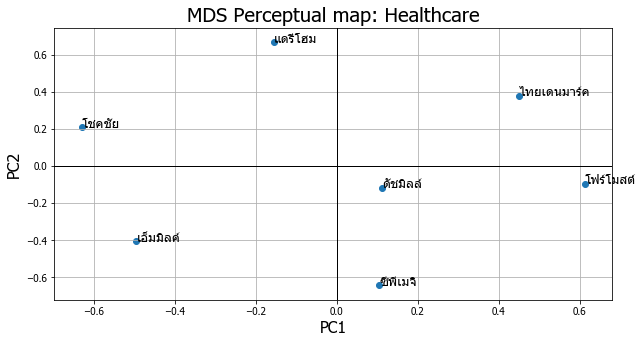

((7, 2), MDS(dissimilarity='precomputed'))

In [22]:
create_MDS_perceptual_map(precomMat_heathcare,'Healthcare', dissim[1])

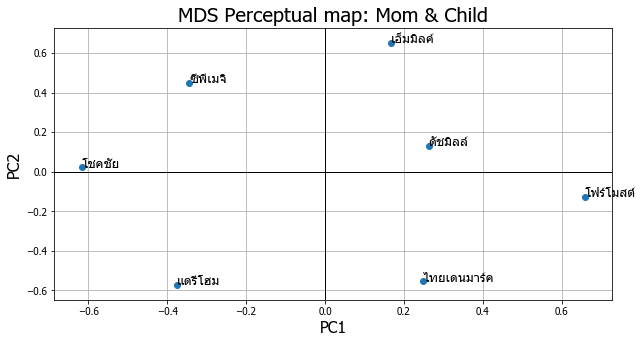

((7, 2), MDS(dissimilarity='precomputed'))

In [23]:
create_MDS_perceptual_map(precomMat_momchild,'Mom & Child', dissim[1])

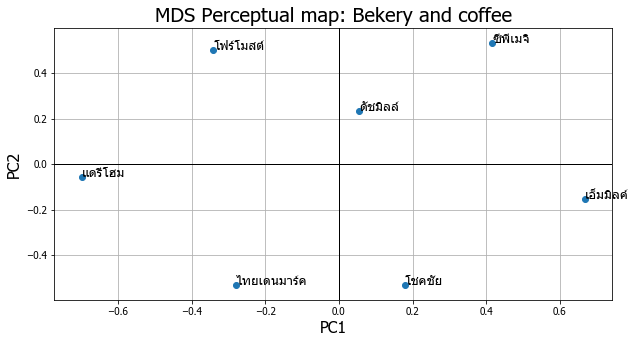

((7, 2), MDS(dissimilarity='precomputed'))

In [24]:
create_MDS_perceptual_map(precomMat_coffee,'Bekery and coffee', dissim[1])

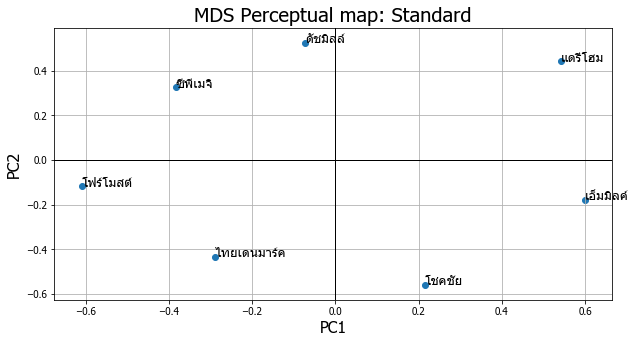

((7, 2), MDS(dissimilarity='precomputed'))

In [25]:
create_MDS_perceptual_map(precomMat_standard,'Standard', dissim[1])

In [26]:
precomMat_price.fillna(1)

,ซีพีเมจิ,ดัชมิลล์,โฟร์โมสต์,แดรี่โฮม,โชคชัย,เอ็มมิลค์,ไทยเดนมาร์ค
ซีพีเมจิ,0.000000,0.659524,0.878571,1.0,1.000000,0.810606,0.985294
ดัชมิลล์,0.659524,0.000000,0.737500,1.0,0.937500,0.900000,0.852778
โฟร์โมสต์,0.878571,0.737500,0.000000,1.0,0.916667,1.000000,0.729167
แดรี่โฮม,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000
โชคชัย,1.000000,0.937500,0.916667,1.0,0.000000,1.000000,0.952381
เอ็มมิลค์,0.810606,0.900000,1.000000,1.0,1.000000,0.000000,1.000000
ไทยเดนมาร์ค,0.985294,0.852778,0.729167,1.0,0.952381,1.000000,0.000000


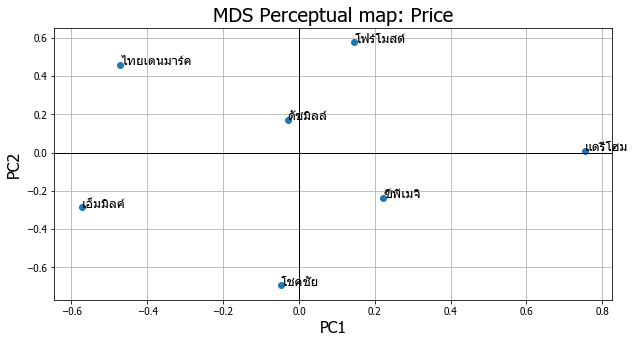

((7, 2), MDS(dissimilarity='precomputed'))

In [27]:
create_MDS_perceptual_map(precomMat_price.fillna(1),'Price', dissim[1])

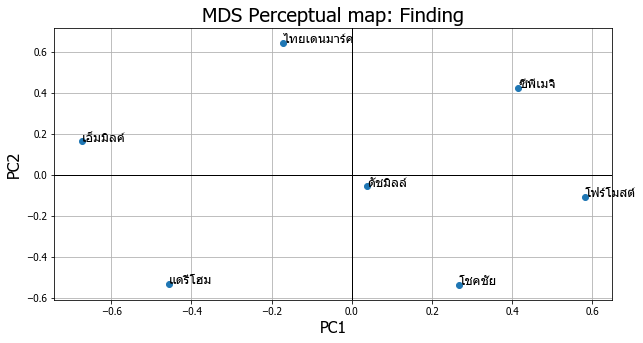

((7, 2), MDS(dissimilarity='precomputed'))

In [28]:
create_MDS_perceptual_map(precomMat_finding,'Finding', dissim[1])

สร้างกราฟ

In [11]:
def stackForGraph(cm):
    stack_matrix = pd.DataFrame(cm.stack())
    stack_matrix.index.names = ['item', 'relatedItem']
    stack_matrix.columns = ['coocValue']
    stack_matrix.reset_index(inplace=True)
    stack_matrix = stack_matrix[(stack_matrix.item != stack_matrix.relatedItem)]
    stack_matrix.sort_values(by='coocValue',ascending=False).head(10)
    return stack_matrix

In [12]:
def plot_pandas_graph(df):
    fig, ax=plt.subplots(figsize=(19,10))
    G=nx.from_pandas_edgelist(df,source='item',target='relatedItem')
    nx.draw(G,with_labels=True, font_family='Tahoma',node_color='yellow')
    plt.show()
    return G

In [13]:
def create_upperTriMatrix(df):
    df.values[np.tril(np.ones(df.shape)).astype(np.bool)] = 0
    return df

Upper matrix plot (Co-occurence without normalization)

In [14]:
#cooc_matrix_ = create_upperTriMatrix(cooc_matrix)
#cooc_matrix_2 = stackForGraph(cooc_matrix_)

cooc_matrix_2 = stackForGraph(cooc_matrix_jacc)
cooc_matrix_2_filter = cooc_matrix_2[(cooc_matrix_2.coocValue >= 0.01)&(cooc_matrix_2.item.isin(brands))]
#cooc_matrix_2_filter = cooc_matrix_2[(cooc_matrix_2.coocValue >= 0.08)]

In [15]:
#cooc_matrix_2.tail(10)

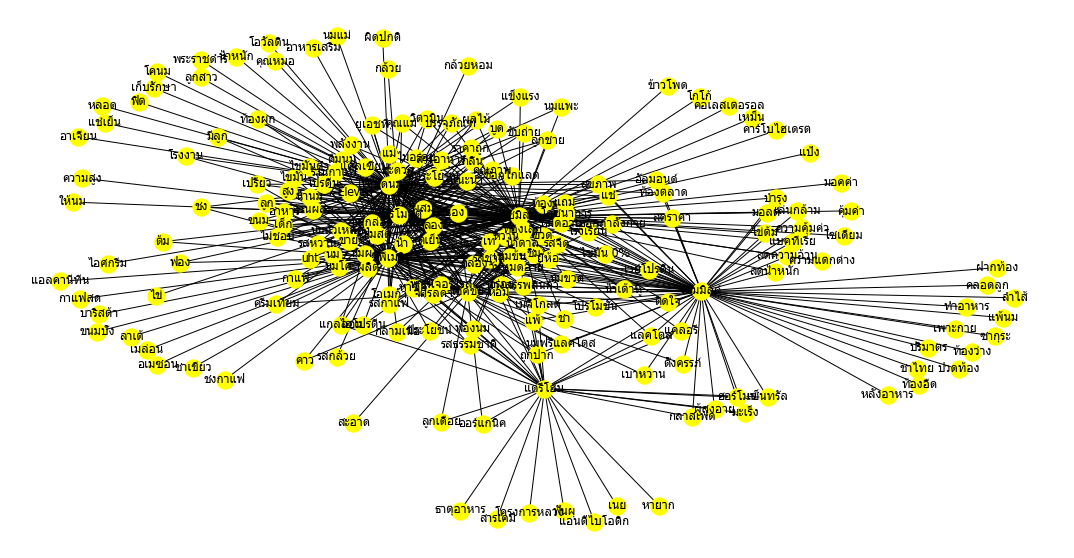

In [31]:
GP = plot_pandas_graph(cooc_matrix_2_filter)

## Louvain Community Detection

In [32]:
from community import community_louvain
partition = community_louvain.best_partition(GP)

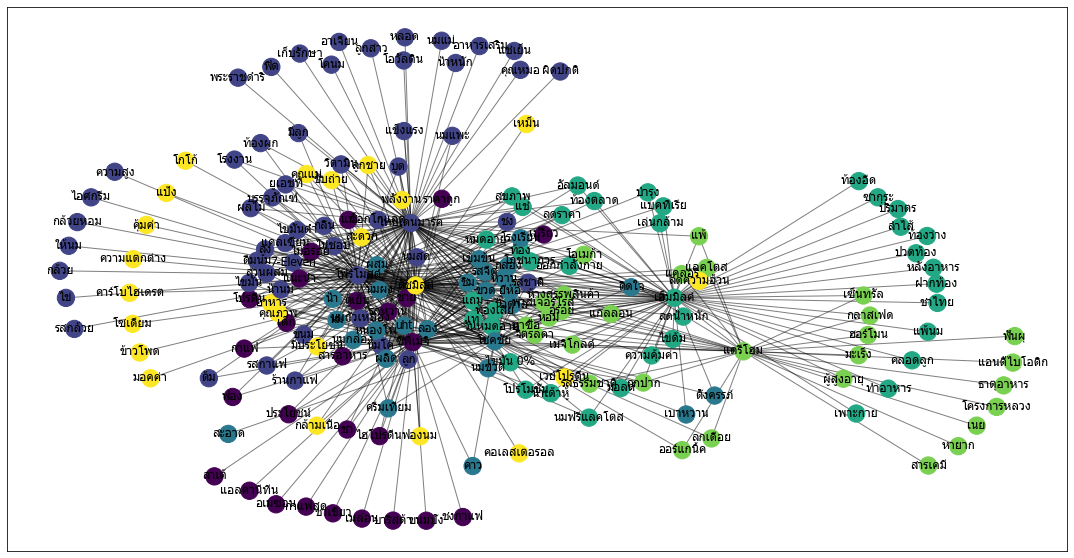

In [34]:
fig, ax=plt.subplots(figsize=(19,10))
G1=nx.from_pandas_edgelist(cooc_matrix_2_filter,source='item',target='relatedItem')
pos = nx.spring_layout(G1)
nx.draw_networkx_nodes(G1, pos, partition.keys(), node_color=list(partition.values()))
nx.draw_networkx_edges(G1, pos, alpha=0.5)
nx.draw_networkx_labels(G1,pos,font_family='Tahoma')
plt.show()

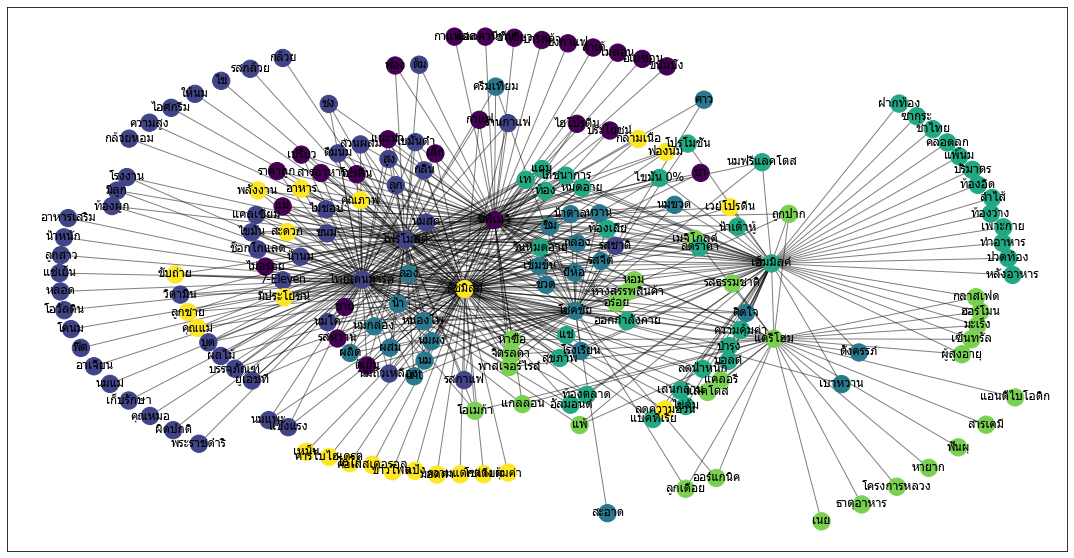

In [35]:
fig, ax=plt.subplots(figsize=(19,10))
G2=nx.from_pandas_edgelist(cooc_matrix_2_filter,source='item',target='relatedItem')
pos = nx.kamada_kawai_layout(G1)
nx.draw_networkx_nodes(G2, pos, partition.keys(), node_color=list(partition.values()))
nx.draw_networkx_edges(G2, pos, alpha=0.5)
nx.draw_networkx_labels(G2,pos,font_family='Tahoma')
plt.show()

## Leiden Community Detection

ย้ายไปทำใน R